## Computing Vision Business Recommendations

### Load in Data

In [74]:
# import necessary packages
import pandas as pd
import numpy as np
import sqlite3
from pandasql import sqldf
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

# load in data sets
boxoffice = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='windows-1252')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)

# connect to database
conn = sqlite3.connect('zippedData/im.db')

pysqldf = lambda q: sqldf(q, globals())

### Create Master Dataset

In [75]:
# join "movie_basics" and "movie_ratings" data
joined = pd.read_sql(
    """SELECT * 
    FROM movie_basics mb 
     JOIN movie_ratings mr 
      ON mb.movie_id=mr.movie_id 
     JOIN directors d 
      ON mb.movie_id = d.movie_id 
     JOIN persons p 
       ON d.person_id = p.person_id;""", conn)

# join "movie_budgets" and "movies" data with "joined" data above
q = """SELECT * FROM joined j JOIN movie_budgets mb ON mb.movie=j.primary_title JOIN movies m ON m.original_title=j.original_title"""
master_df = pysqldf(q).drop_duplicates(subset='primary_title', keep='first')

### Data Cleaning

In [76]:
# drop unneccessary columns
new_master_df = master_df.drop(["original_title", "id", "start_year", "movie", "title", "genre_ids", "original_language", "birth_year", "death_year", 'release_date'], axis=1)

# rename "duplicate" columns to reflect data source
new_master_df = new_master_df.rename(columns={"vote_average": "tmdb_vote_average",
                                              "vote_count": "tmdb_vote_count", 
                                              "averagerating": "imdb_average_rating", 
                                              "numvotes": "imdb_vote_count"})

# convert the "genres" and "primary_profession" column into a list
new_master_df["genres"] = new_master_df["genres"].str.split(',')
new_master_df["primary_profession"] = new_master_df["primary_profession"].str.split(',')
new_master_df

# convert "domestic_gross", "production_budget", "worldwide_gross" to integers 
new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['worldwide_gross'] = new_master_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)
final_master_df = new_master_df
final_master_df

# calculate "domestic_profit" and "worldwide_profit" by subtracting "production_budget" from "domestic_gross" and "worldwide_gross"
final_master_df['domestic_profit'] = final_master_df['domestic_gross'] - final_master_df['production_budget']
final_master_df['worldwide_profit'] = final_master_df['worldwide_gross'] - final_master_df['production_budget']
final_master_df.head(3)

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
5,tt0326592,The Overnight,88.0,None,7.5,24,nm1208371,Jed I. Goodman,"[camera_department, writer, producer]",200000,1109808,1165996,6.576,6.0,200,909808,965996
7,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,nm0758574,Walter Salles,"[director, producer, writer]",25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698


### Choosing the Metric: Profit

There is a slightly positive correlation between rating and profit for movies with a minimum of 1000 votes.

In [77]:
# correlation between "popularity" and "worldwide_profit"
popularity_correlation = final_master_df['popularity'].corr(final_master_df['worldwide_profit'])
popularity_correlation

0.597382642103372

There is a slightly positive correlation between popularity and worldwide profit.

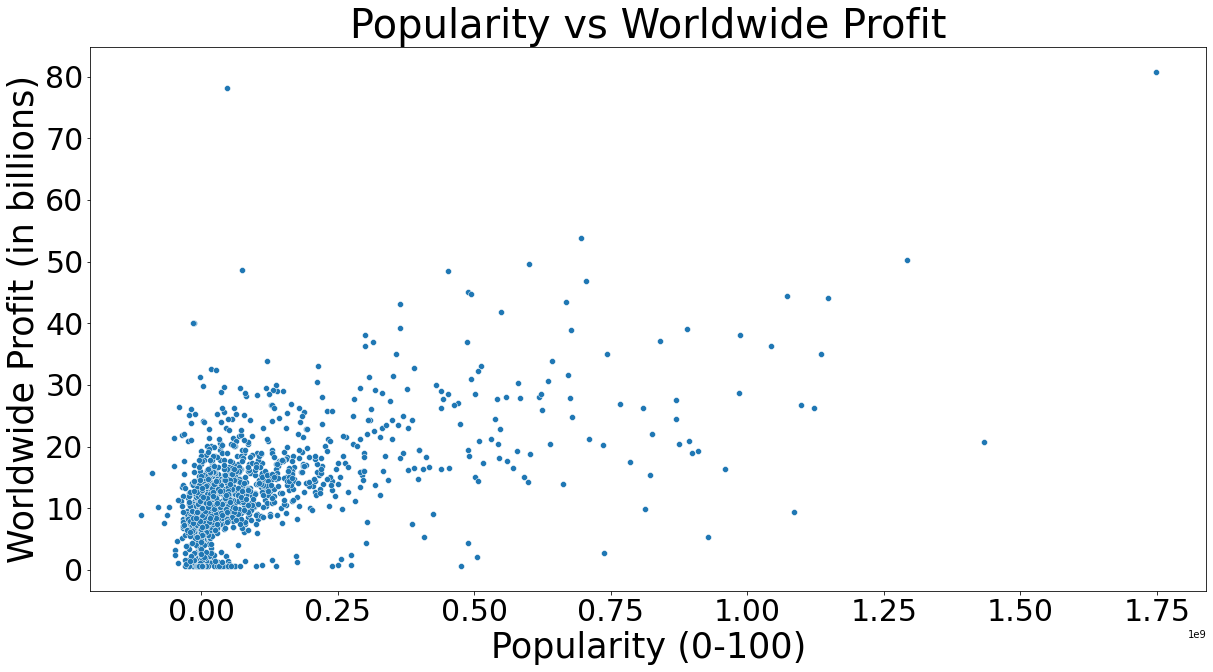

In [101]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['popularity'], 
                x=final_master_df['worldwide_profit'])

# set barplot title and axes labels
plt.title(label = "Popularity vs Worldwide Profit", fontsize=40)
plt.xlabel("Popularity (0-100)", fontsize=35)
plt.ylabel("Worldwide Profit (in billions)", fontsize=35)

# set x and y tick size
plt.xticks(size = 30)
plt.yticks(size = 30);

In [79]:
# correlation between "imdb_average_rating" and "worldwide_profit"
average_rating = final_master_df['imdb_average_rating'].corr(final_master_df['worldwide_profit'])
average_rating

0.25093081799095923

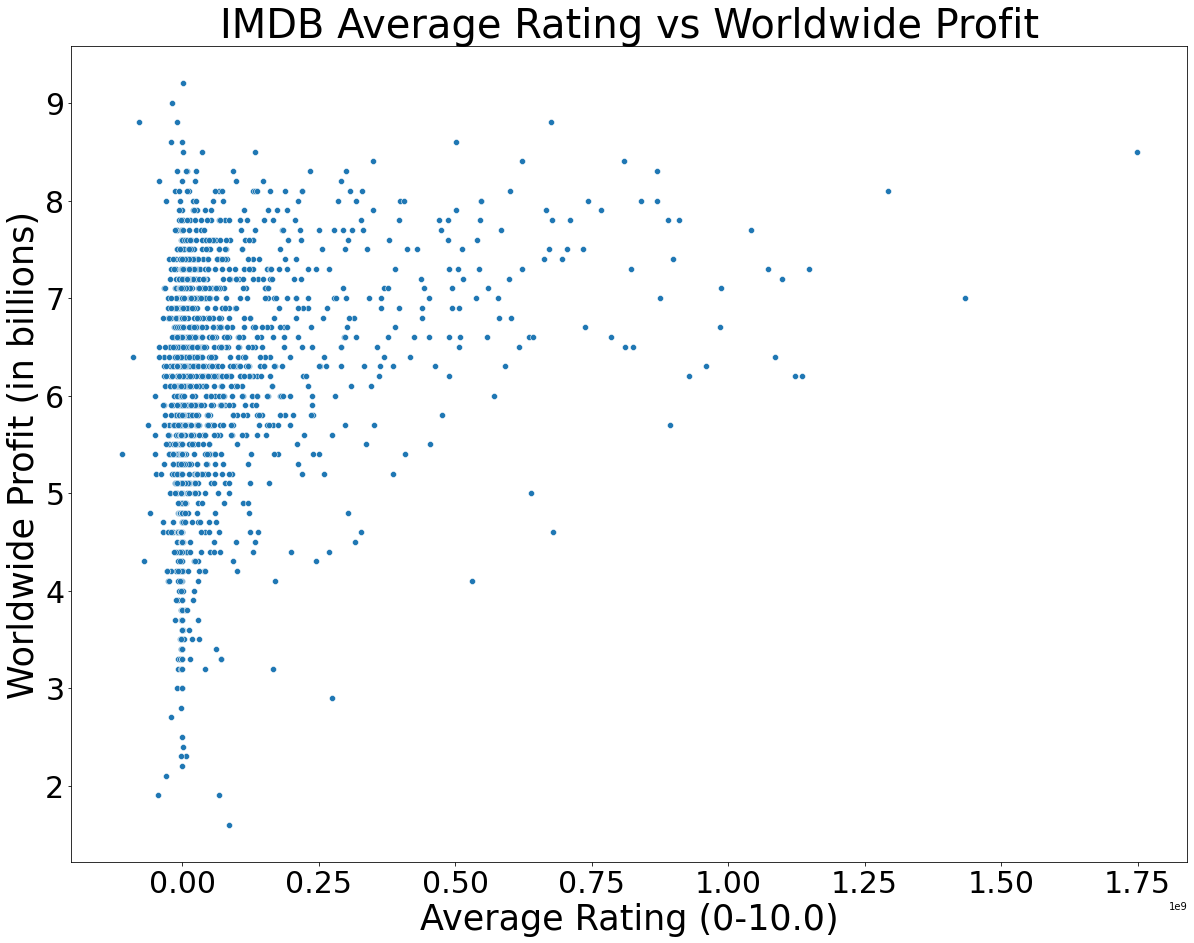

In [100]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 15))
sns.scatterplot(y=final_master_df['imdb_average_rating'], 
            x=final_master_df['worldwide_profit'])

# set barplot title and axes labels
plt.title(label = "IMDB Average Rating vs Worldwide Profit", fontsize=40)
plt.xlabel("Average Rating (0-10.0)", fontsize=35)
plt.ylabel("Worldwide Profit (in billions)", fontsize=35)

# set x and y tick size
plt.xticks(size = 30)
plt.yticks(size = 30);

### Recommendation #1: Genre

In [81]:
# explode table based on genres
final = final_master_df
final = final.dropna()
final.reset_index(drop=True)
final = final.explode('genres')
final.head(3)

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,Action,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Animation,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Comedy,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294


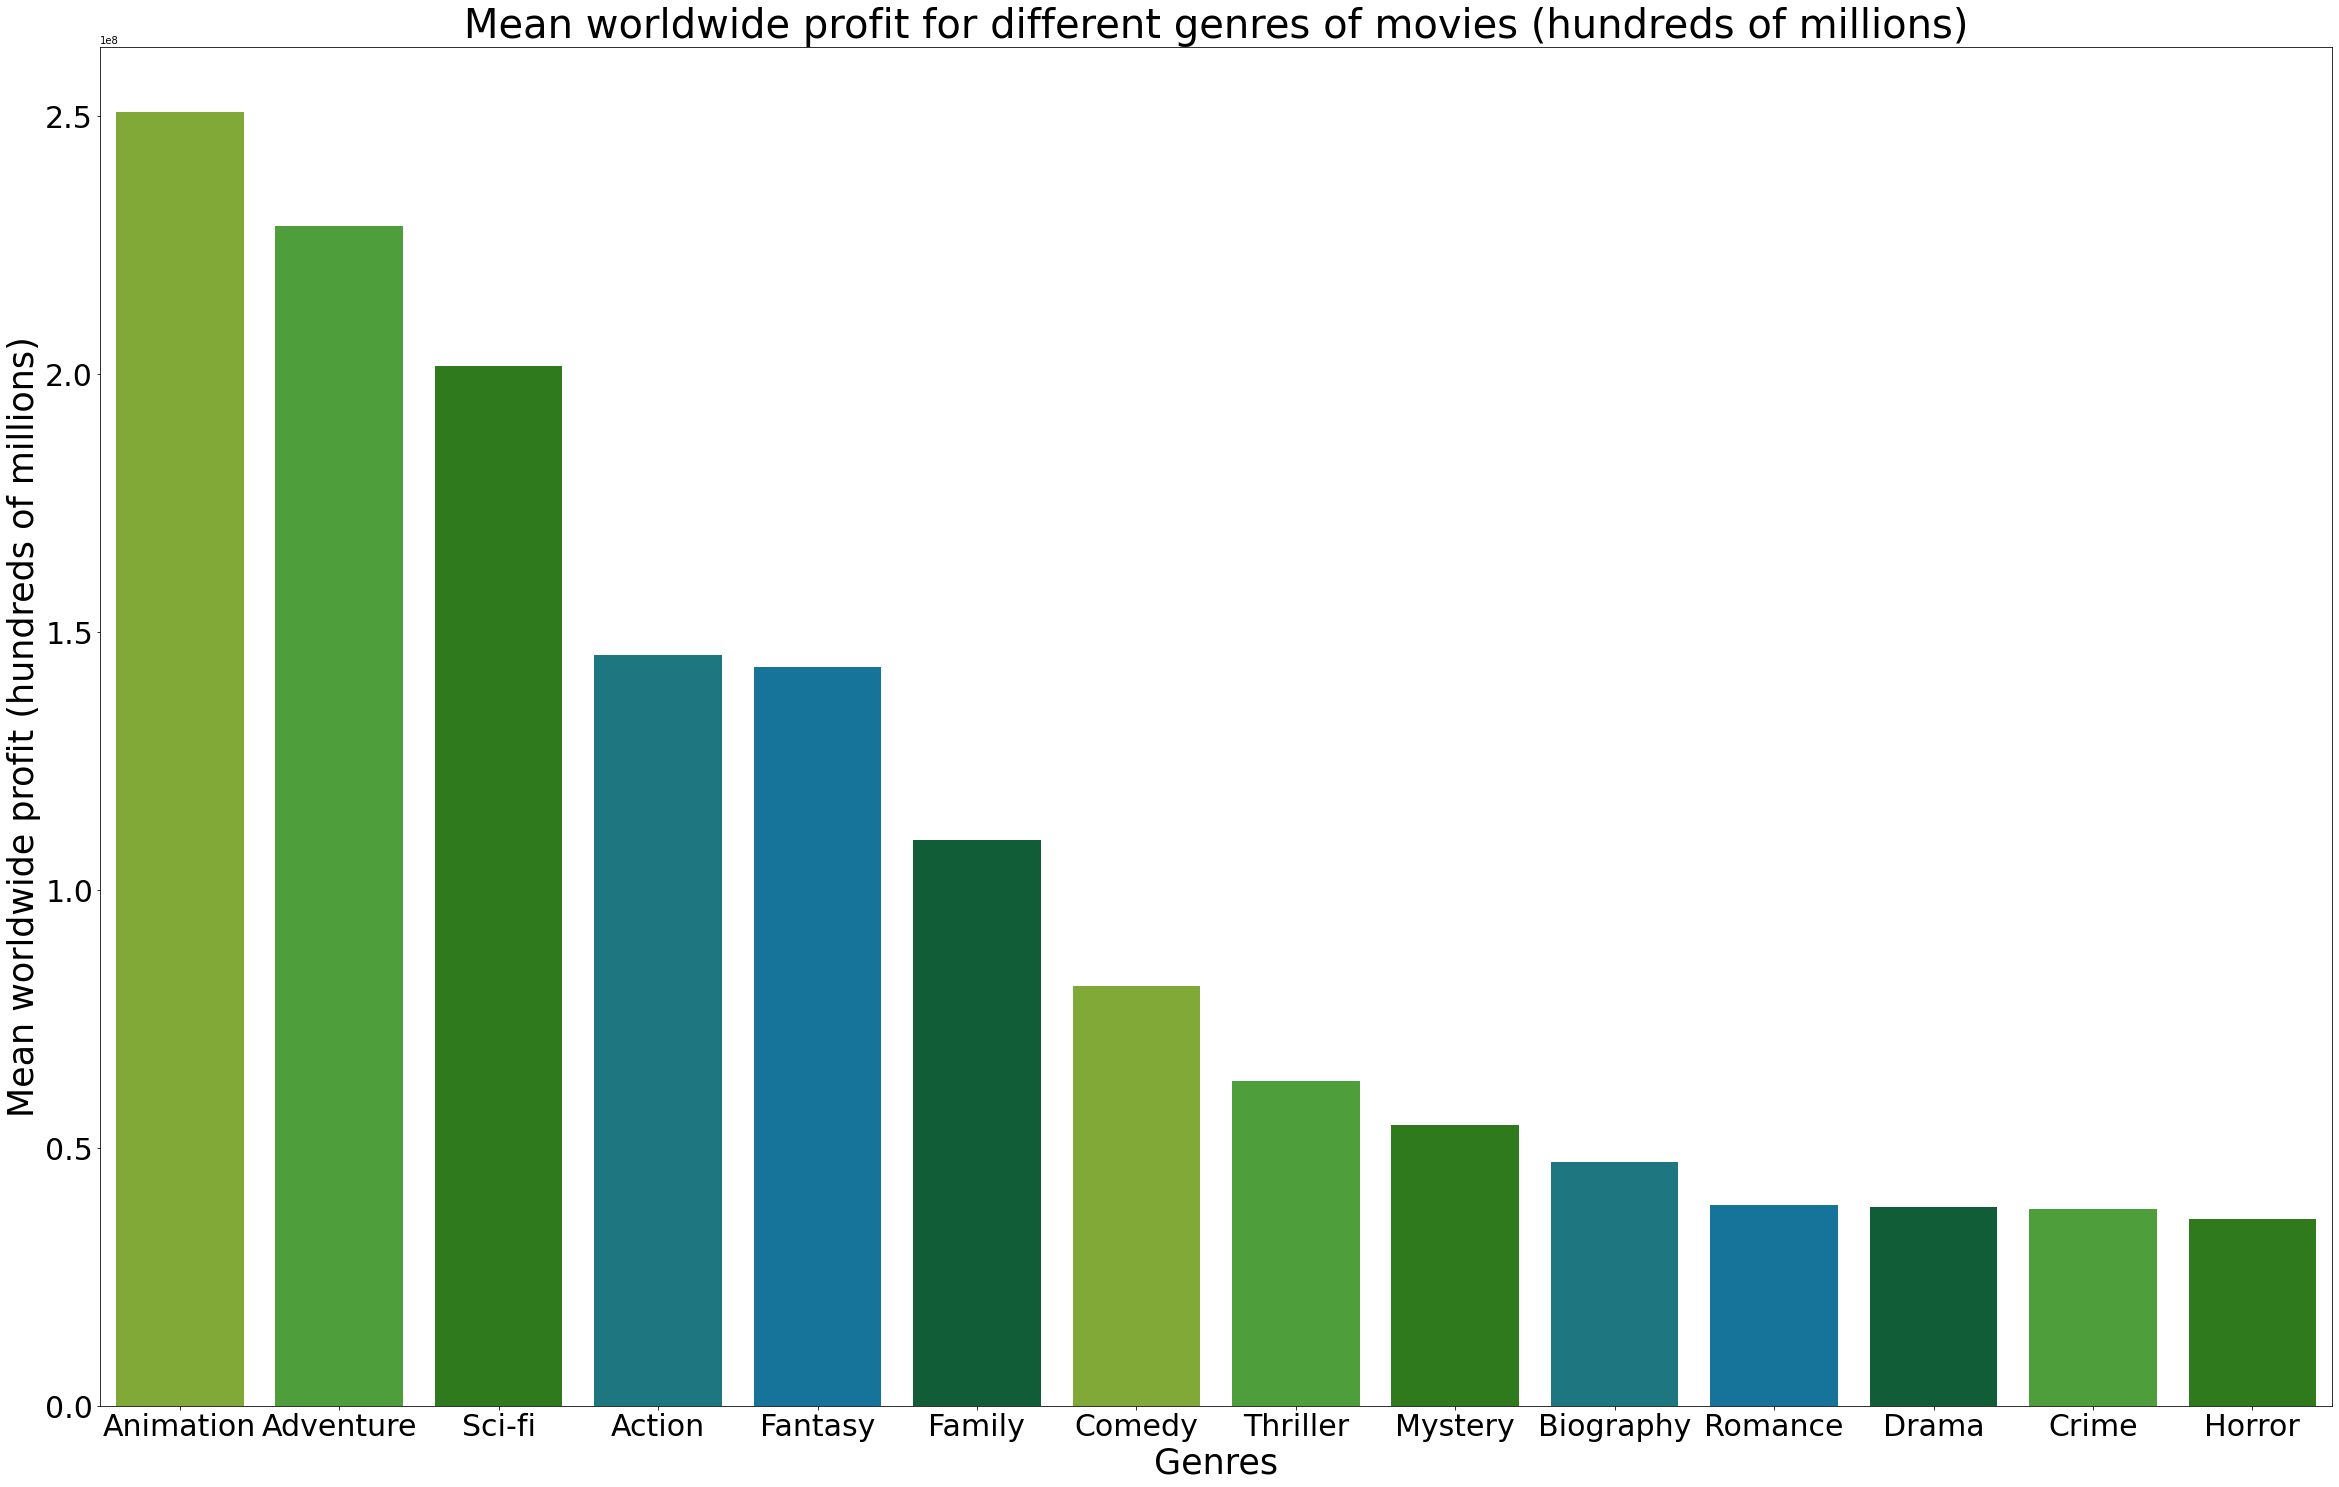

In [82]:
# find the mean of different genres of movies
comedy = final[final['genres'] == 'Comedy'].mean()
action = final[final['genres'] == 'Action'].mean()
animation = final[final['genres'] == 'Animation'].mean()
drama = final[final['genres'] == 'Drama'].mean()
horror = final[final['genres'] == 'Horror'].mean()
mystery = final[final['genres'] == 'Mystery'].mean()
scifi = final[final['genres'] == 'Sci-Fi'].mean()
adventure = final[final['genres'] == 'Adventure'].mean()
romance = final[final['genres'] == 'Romance'].mean()
thriller = final[final['genres'] == 'Thriller'].mean()
crime = final[final['genres'] == 'Crime'].mean()
biography = final[final['genres'] == 'Biography'].mean()
fantasy = final[final['genres'] == 'Fantasy'].mean() 
family = final[final['genres'] == 'Family'].mean()


# create dictionary of genres and means
genre_profit = {"Comedy":comedy, "Action": action, "Animation": animation, "Drama": drama, "Horror": horror,
               "Mystery": mystery, "Sci-fi": scifi, "Adventure": adventure, "Romance": romance, "Thriller": thriller, 
                "Crime": crime, "Biography": biography, "Fantasy": fantasy, "Family": family}

# create a dataframe from the dictionary above
mean_df = pd.DataFrame(genre_profit)

# get worldwide profit; sort and prepare for graph below
genres = mean_df.iloc[[10]]
genres = genres.T.sort_values("worldwide_profit", ascending=False)
genres = genres.reset_index()

# graph mean worldwide profit for different genres of movies
colors = ['#86BC25', '#43B02A', '#26890D', '#0D8390', 
          '#007CB0', '#046A38', '#86BC25','#43B02A', 
          '#26890D', '#0D8390', '#007CB0', '#046A38', 
          '#43B02A', '#26890D']
plt.figure(figsize=(40, 25))
sns.barplot(x="index", y="worldwide_profit", data=genres, palette = colors)

# set barplot title and axes labels
plt.xlabel('Genres', fontsize = 35)
plt.ylabel('Mean worldwide profit (hundreds of millions)', fontsize = 35)
plt.title('Mean worldwide profit for different genres of movies (hundreds of millions)', fontsize = 40);

# set x and y tick size
plt.xticks(size = 30)
plt.yticks(size = 30);

### Recommendation #2: Directors

In [83]:
directors_profit = final.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit.head(3)

,worldwide_gross
primary_name,
Joss Whedon,1.460475e+09
Anthony Russo,1.300869e+09
Adam Green,1.272470e+09


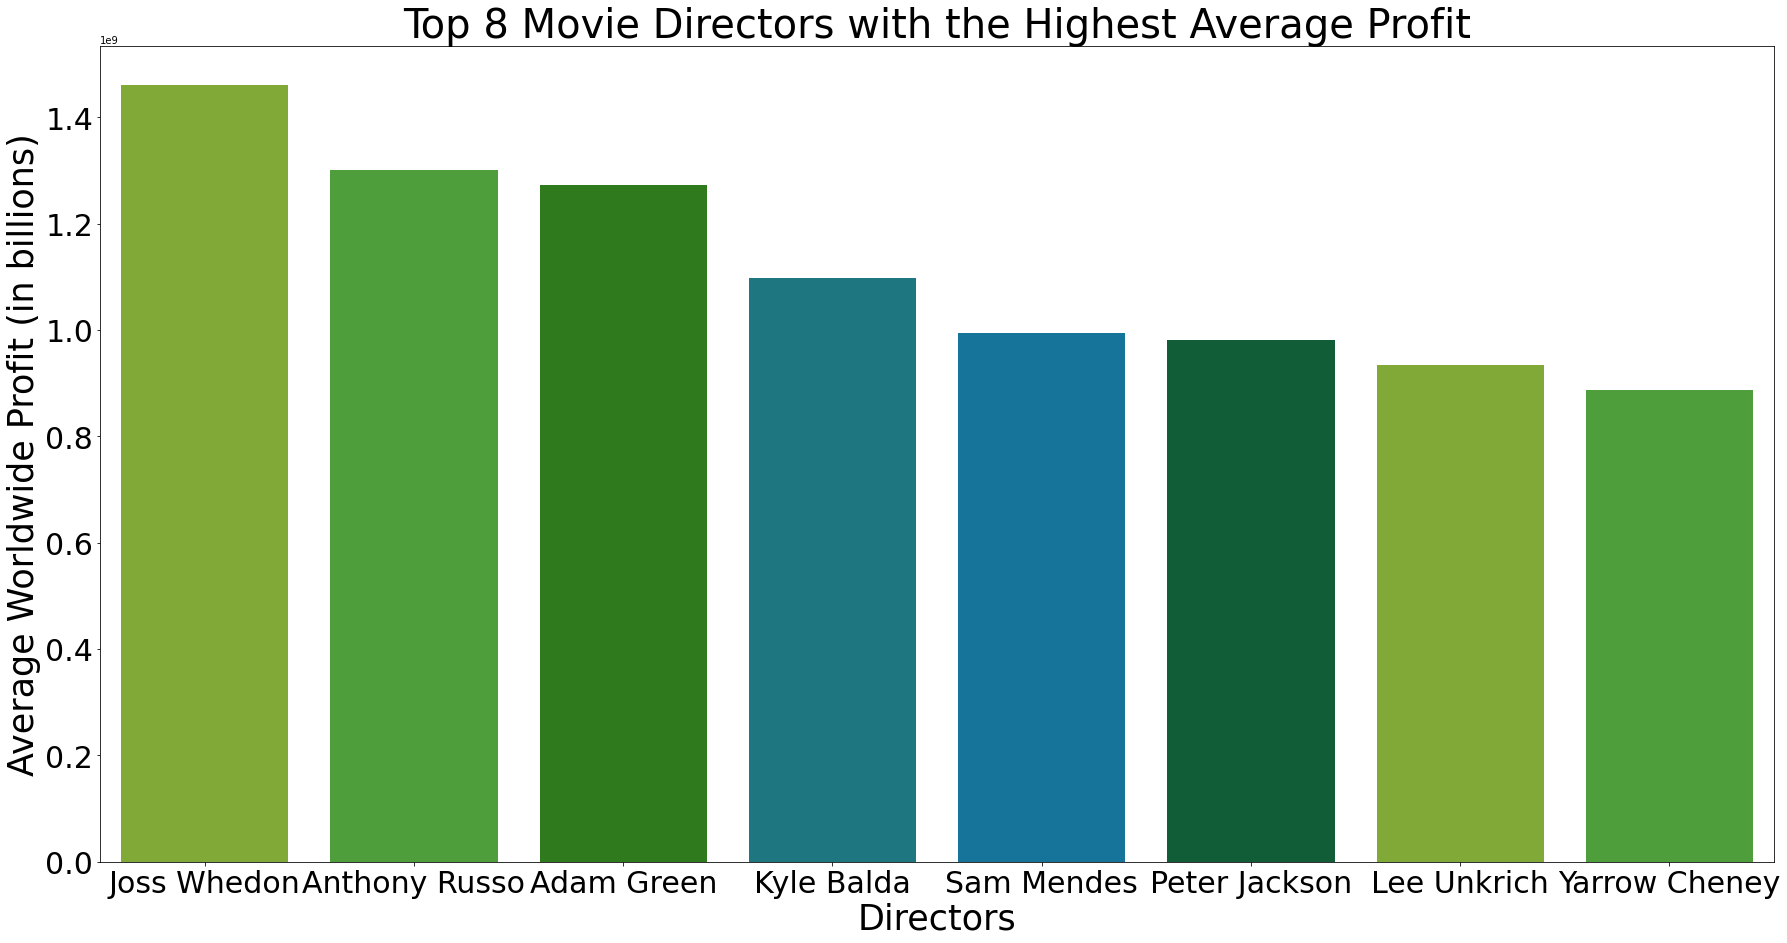

In [84]:
# create barplot of the top 8 directors with Deloitte color palette
d = directors_profit.head(8)
plt.figure(figsize=(30, 15))
colors = ['#86BC25', '#43B02A', '#26890D', '#0D8390', 
          '#007CB0', '#046A38', '#86BC25','#43B02A', 
          '#26890D', '#0D8390', '#007CB0', '#046A38', 
          '#43B02A', '#26890D']
sns.barplot(x=d.index, y= d['worldwide_gross'], palette = colors)  

# set barplot title and axes labels
plt.title(label = "Top 8 Movie Directors with the Highest Average Profit", fontsize=40)
plt.xlabel("Directors", fontsize=35)
plt.ylabel("Average Worldwide Profit (in billions)", fontsize=35)

# set x and y tick size
plt.xticks(size = 30)
plt.yticks(size = 30);

In [85]:
# numerical summary of the data above
directors_profit = final.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit.head(8)

,worldwide_gross
primary_name,
Joss Whedon,1.460475e+09
Anthony Russo,1.300869e+09
Adam Green,1.272470e+09
Kyle Balda,1.097532e+09
Sam Mendes,9.950740e+08
Peter Jackson,9.804142e+08
Lee Unkrich,9.334438e+08
Yarrow Cheney,8.867505e+08


In [86]:
# top 3 directors
directors_profit.head(3)

,worldwide_gross
primary_name,
Joss Whedon,1.460475e+09
Anthony Russo,1.300869e+09
Adam Green,1.272470e+09


### Recommendation #3: Runtime

#### Confidence Intervals

Given that our data set is not representative of a population of all movies rather it is a sample, we decided it would be best to find the confidence interval of the runtime minutes of a movie to have a range of values that most movies average around. With the confidence interval, we want to conduct hypothesis testing to test whether the range of values impacts profitability which will be done after calculating the confidence interval.

In [87]:
# runtime statistics across all genres
runtime = pd.DataFrame(final, columns=['runtime_minutes'])
print(runtime.describe()) 

       runtime_minutes
count      4293.000000
mean        106.106918
std          17.402236
min          41.000000
25%          94.000000
50%         104.000000
75%         116.000000
max         180.000000


In [88]:
# profitability statistics across all genres
profit = pd.DataFrame(final, columns=['worldwide_profit'])
print(profit.describe())

       worldwide_profit
count      4.293000e+03
mean       8.924564e+07
std        1.867543e+08
min       -1.104502e+08
25%       -1.614407e+06
50%        1.779650e+07
75%        9.080884e+07
max        1.748134e+09


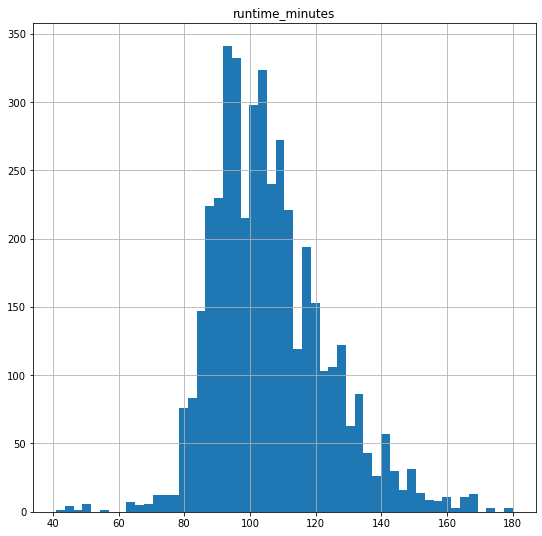

In [89]:
pd.DataFrame(runtime).hist(bins='auto',figsize=(9,9));

As you can see in the histogram above, the distribution of the runtime is unimodal and looks almost normal. Once again, given that our data is a sample rather than the population, we decided to directly calculate the confidence intervals based on the given data.

In [90]:
runtime 
# we want to see if there is a relationship between runtime and profitability and have a confidence interval as a 
# recommendation for Computing Vision

,runtime_minutes
0,91.0
0,91.0
0,91.0
7,124.0
7,124.0
...,...
7375,127.0
7384,155.0
7384,155.0
7384,155.0


In [91]:
# calculating the confidence interval within 1 standard deviation of the mean. A 68% chance that the runtime value would 
# fall in this range
stats.norm.interval(0.68, loc=runtime.mean(), scale=runtime.std())

(array([88.80112739]), array([123.41270908]))

We chose one standard deviation for runtime, because we didn't want a wide range of values for the runtime of the movie that would have a significant impact on other factors such as popularity or how many people watched it (this is an assumption).

According to our calculation above the runtime within one standard deviation ranges from approximately 87.3 minutes to 122.7 minutes.

#### Hypothesis Testing

Now that we have our confidence interval, we want to test if having a value within this range of runtime minutes (inclusive) positively impacts profitability. In simpler terms, does this range of runtime minutes ensure that the movie would be more profitable than movies with runtimes outside of this range.

Null Hypothesis: A runtime between 87.3 and 122.7 minutes will negatively impact or not impact profitability.

Alternate Hypothesis: A runtime between 87.3 and 122.7 minutes will positively impact profitability

In [92]:
sample_df1 = final[final['runtime_minutes'].between(87.29524865, 122.67584961, inclusive=True)]
sample_df1.head(3)

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,Action,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Animation,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Comedy,1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294


In [93]:
sample_df1['worldwide_profit'].describe() #mean lowered in this range

count    3.144000e+03
mean     6.961729e+07
std      1.453296e+08
min     -1.104502e+08
25%     -2.000000e+06
50%      1.406408e+07
75%      7.482962e+07
max      1.122470e+09
Name: worldwide_profit, dtype: float64

In [94]:
group_runtime = sample_df1['runtime_minutes']
group_profit = sample_df1['worldwide_profit']

t_statistic, p_value = stats.ttest_ind(group_runtime,group_profit)

alpha = 0.05

In [95]:
#Results Interpretation
if p_value < alpha:
    print("Reject null hypothesis, a runtime between 87.3 and 122.7 minutes will positively impact profitability")
else:
    print("Fail to reject null hypothesis, a runtime between 87.3 and 122.7 minutes will negatively impact or not impact profitability")

Reject null hypothesis, a runtime between 87.3 and 122.7 minutes will positively impact profitability


#### Additional Testing to Ensure Accurate Results

In [96]:
stats.norm.interval(0.95, loc=runtime.mean(), scale=runtime.std())

(array([71.99916229]), array([140.21467419]))

In [97]:
sample_df2 = final[final['runtime_minutes'].between(122.67584961, 139.85113007, inclusive=True)]
sample_df3 = final[final['runtime_minutes'].between(70.1199682, 87.29524865, inclusive=True)]

In [98]:
sample_df3['worldwide_profit'].describe()

count    4.070000e+02
mean     2.934803e+07
std      8.461737e+07
min     -4.888407e+07
25%     -1.400000e+06
50%      1.659955e+06
75%      3.335931e+07
max      8.117505e+08
Name: worldwide_profit, dtype: float64

In [99]:
sample_df2['worldwide_profit'].describe()

count    5.020000e+02
mean     1.706217e+08
std      2.603411e+08
min     -5.033500e+07
25%      4.868073e+06
50%      6.023084e+07
75%      2.281781e+08
max      1.433855e+09
Name: worldwide_profit, dtype: float64